# Pace of Roll Analysis - EURO STOXX 50 Futures (FESX)

This notebook demonstrates how to use the **A7 Market Insights API** to analyze the "Pace of the Roll" for EURO STOXX 50 Index Futures (FESX).

## What is "Pace of Roll"?
As futures contracts approach expiration, trading activity gradually shifts from the front month contract to the next expiry. The "Pace of Roll" measures this transition by tracking volume and open interest migration.

## Instrument Details
- **Market:** XEUR (Eurex)
- **Instrument:** FESX (EURO STOXX 50 Index Futures)
- **Market Segment ID:** 675
- **Type:** Quarterly futures contracts (Mar, Jun, Sep, Dec)

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from a7 import A7Client
from pprint import pprint

# Load environment variables
load_dotenv()

# Initialize A7 Client
client = A7Client(
    token=os.getenv("A7_API_TOKEN"),
    base_url=os.getenv("A7_BASE_URL", "https://a7.deutsche-boerse.com/api/")
)

print("A7 Client initialized")

A7 Client initialized


## 1. Discover Available Market Segments

First, we need to see which market segments are available for Pace of Roll analysis.

In [39]:
try:
    segments = client.insights.get_por_market_segments()
    print(f"Found {len(segments)} market segments available for POR analysis")
    print(f"First 10: {segments[:10]}")
    
    if "FESX" in segments:
        print("FESX segment verified")
    else:
        print(f"Warning: FESX not found. Available segments: {segments}")
        
except Exception as e:
    print(f"Error retrieving segments: {e}")
    segments = []

Found 10 market segments available for POR analysis
First 10: ['FBTP', 'FDAX', 'FDXM', 'FESB', 'FESX', 'FGBL', 'FGBM', 'FGBS', 'FOAT', 'FXXP']
FESX segment verified


## 2. Select FESX and List Available Rolls

We'll analyze **FESX** (EURO STOXX 50 Futures), which is one of the most liquid European equity index derivatives.
A "roll" represents the transition period between two contract expiries.

In [40]:
# Select FESX as the target segment
target_segment = "FESX"

# Fallback logic if FESX is not available
if target_segment not in segments and segments:
    print(f"Warning: FESX not found, defaulting to {segments[0]}")
    target_segment = segments[0]
else:
    print(f"Target segment: {target_segment}")

print(f"\nFetching available rolls for {target_segment}...")

try:
    rolls = client.insights.get_por_rolls(target_segment)
    print(f"Retrieved {len(rolls)} roll periods")
    print(f"Available rolls: {rolls}")
    
    if rolls:
        print(f"Roll data type: {type(rolls).__name__}")
        print(f"Latest roll: {rolls[-1]}")
    
except Exception as e:
    print(f"Error retrieving rolls: {e}")
    rolls = []

Target segment: FESX

Fetching available rolls for FESX...
Retrieved 100 roll periods
Available rolls: [200203, 200206, 200209, 200212, 200303, 200306, 200309, 200312, 200403, 200406, 200409, 200412, 200503, 200506, 200509, 200512, 200603, 200606, 200609, 200612, 200703, 200706, 200709, 200712, 200803, 200806, 200809, 200812, 200903, 200906, 200909, 200912, 201003, 201006, 201009, 201012, 201103, 201106, 201109, 201112, 201203, 201206, 201209, 201212, 201303, 201306, 201309, 201312, 201403, 201406, 201409, 201412, 201503, 201506, 201509, 201512, 201603, 201606, 201609, 201612, 201703, 201706, 201709, 201712, 201803, 201806, 201809, 201812, 201903, 201906, 201909, 201912, 202003, 202006, 202009, 202012, 202103, 202106, 202109, 202112, 202203, 202206, 202209, 202212, 202303, 202306, 202309, 202312, 202403, 202406, 202409, 202412, 202503, 202506, 202509, 202512, 202603, 202606, 202609, 202612]
Roll data type: list
Latest roll: 202612


## 3. Retrieve Pace of Roll Data

Now we fetch the POR data for a specific roll. We'll look at the most recent available roll.

**Parameters:**
- `days`: Number of days to look back (e.g., 15)
- `n`: Number of data points to retrieve (e.g., 20)
- `comp`: Composition type
  - `'c'` = concurrent (front month vs next month)
  - `'s'` = serial (sequential contracts)

In [41]:
if rolls:
    # Use a recent past roll instead of the latest future roll
    # Try the roll from September 2024 (202409)
    target_roll = 202409 if 202409 in rolls else rolls[-5]  # Fallback to 5th from end
    print(f"Analyzing roll: {target_roll}")

    try:
        por_data = client.insights.get_por_data(
            market_segment=target_segment,
            roll=target_roll,
            days=15,
            n=20,
            comp="c"  # Concurrent composition
        )
        
        print("POR data retrieved successfully")
        
        # Inspect the response structure
        print(f"\nResponse type: {type(por_data).__name__}")
        print(f"Available keys: {list(por_data.keys())}")
        
        # Check data dimensions
        print("\nData dimensions:")
        for key in por_data.keys():
            value = por_data[key]
            if isinstance(value, list):
                print(f"  {key}: {len(value)} data points")
            else:
                print(f"  {key}: {type(value).__name__}")
        
        # Show sample data
        if 'dte' in por_data and por_data['dte']:
            print("\nSample data (first 3 points):")
            for i in range(min(3, len(por_data.get('dte', [])))):
                dte_val = por_data['dte'][i]
                r0_val = por_data.get('r_0', [])[i] if i < len(por_data.get('r_0', [])) else 'N/A'
                print(f"  DTE={dte_val}, r_0={r0_val}")
        
    except Exception as e:
        print(f"Error retrieving POR data: {e}")
        print(f"Exception type: {type(e).__name__}")
        por_data = None
else:
    print("No rolls available to analyze")
    por_data = None

Analyzing roll: 202409
POR data retrieved successfully

Response type: dict
Available keys: ['dte', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_10', 'r_11', 'r_12', 'r_13', 'r_14', 'r_15', 'r_16', 'r_17', 'r_18', 'r_19', 'r_20', 'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5']

Data dimensions:
  dte: 15 data points
  r_0: 15 data points
  r_1: 15 data points
  r_2: 15 data points
  r_3: 15 data points
  r_4: 15 data points
  r_5: 15 data points
  r_6: 15 data points
  r_7: 15 data points
  r_8: 15 data points
  r_9: 15 data points
  r_10: 15 data points
  r_11: 15 data points
  r_12: 15 data points
  r_13: 15 data points
  r_14: 15 data points
  r_15: 15 data points
  r_16: 15 data points
  r_17: 15 data points
  r_18: 15 data points
  r_19: 15 data points
  r_20: 15 data points
  q_0: 15 data points
  q_1: 15 data points
  q_2: 15 data points
  q_3: 15 data points
  q_4: 15 data points
  q_5: 15 data points

Sample data (first 3 points):
  DTE=14, r_0=0.026487
 

## 4. Inspect and Visualize the Data

Let's examine the roll progression data and visualize it.

**Key Metrics:**
- `dte`: Days to Expiry (time remaining until contract expiration)
- `r_0`: Current roll ratio (% of volume/OI in front month)
- `r_1`: Previous contract ratio

The roll ratio shows how trading activity shifts from the expiring contract to the next one.

In [42]:
if por_data and por_data.get('dte'):
    # Create a DataFrame for easier analysis
    df = pd.DataFrame({
        'Days to Expiry': por_data.get('dte', []),
        'Current Roll Ratio': por_data.get('r_0', [])
    })
    
    # Filter out None values
    df = df.dropna()
    
    print("Data Summary:")
    print(f"  Total data points: {len(df)}")
    if not df.empty:
        print(f"  DTE range: {df['Days to Expiry'].min()} to {df['Days to Expiry'].max()} days")
        print(f"  Roll ratio range: {df['Current Roll Ratio'].min():.2%} to {df['Current Roll Ratio'].max():.2%}")
    
    print("\nFirst 5 data points:")
    print(df.head())
    
    print("\nLast 5 data points:")
    print(df.tail())
else:
    print("No data available for inspection")
    df = None

Data Summary:
  Total data points: 15
  DTE range: 0 to 14 days
  Roll ratio range: 2.53% to 100.00%

First 5 data points:
   Days to Expiry  Current Roll Ratio
0              14            0.026487
1              13            0.026301
2              12            0.025252
3              11            0.031337
4              10            0.040775

Last 5 data points:
    Days to Expiry  Current Roll Ratio
10               4            0.337082
11               3            0.502836
12               2            0.662697
13               1            0.718558
14               0            1.000000


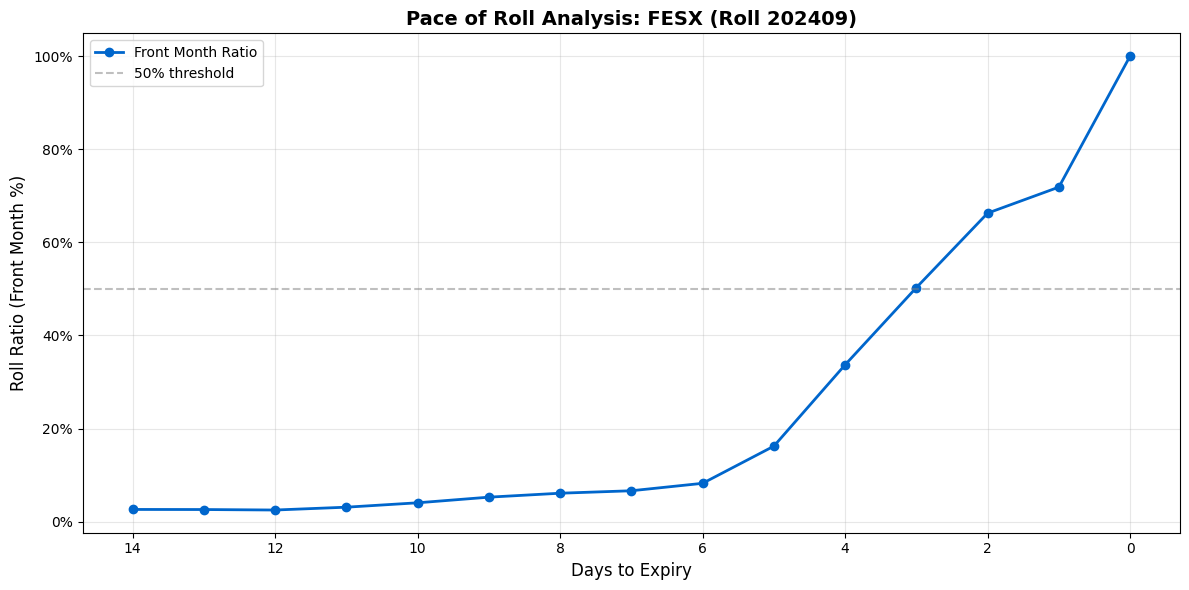

Visualization complete


In [43]:
if df is not None and not df.empty:
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df['Days to Expiry'], df['Current Roll Ratio'], 
             marker='o', linestyle='-', color='#0066cc', linewidth=2, 
             markersize=6, label='Front Month Ratio')
    
    # Add horizontal reference line at 50%
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
    
    plt.title(f"Pace of Roll Analysis: {target_segment} (Roll {target_roll})", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Days to Expiry", fontsize=12)
    plt.ylabel("Roll Ratio (Front Month %)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().invert_xaxis()  # DTE counts down to expiration
    
    # Format y-axis as percentage
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization complete")
else:
    print("No data to visualize")